# Leanardo (robot_artist)
This notebook peforms the same tasks as `run_drawing_robot.py` but in a way that aims to explain how it all works. Familiarity with Python is helpful but not necessary to follow along. 


In [3]:
# the doc string in run_drawing_robot does a nice job of explaining what the program does
# so we can import and print it here
from run_drawing_robot import __doc__
print(__doc__)


This script runs a drawing robot that takes user input, generates a drawing based on the input,
and then uses a robot to draw the generated image. The script uses audio prompts for user interaction,
speech-to-text transcription for input, and various drawing and simulation modules for generating and
executing the drawing.

The main steps of the script include:
1. Playing an audio prompt to ask the user what they would like the robot to draw.
2. Recording and transcribing the user's response (or using a provided prompt).
3. Generating a drawing based on the transcription.
4. Tracing the edges of the generated image.
5. Scaling the contours of the traced image to fit a canvas.
6. Generating G-code instructions for the robot based on the scaled contours.
7. Loading the robot simulation environment.
8. Creating a robot program using the generated G-code and executing it.



## Importing modules from repo
here we import the modules implemented in this repo. The code from those modules does most of the heavy lifting. 

In [4]:
# This is used to get a shared logger instance for logging messages
# project_init also sets some environment variables (like the OPENAI_API_KEY)
from project_init import SharedLogger

log = SharedLogger.get_logger()

# These are used for recording and managing audio recordings
from text_to_speech.dictate import RecordingSetting, Recordings

# This function is used to record audio and transcribe it into text
from speech_to_text.transcribe import record_and_transcribe

# This function is used to generate an image based on given parameters
from drawing.generate_img import generate_drawing, make_prompt

# This function is used to trace the edges of an image
from drawing.trace_edges import trace_image

# This function is used to scale the contours of an image to fit a canvas
from drawing.canvas_scale import scale_contours_to_canvas

# This function is used to generate G-code instructions for a drawing
from drawing.gcode import make_gcode

# This function is used to load a robot station in the simulation environment
from simulation.launch_rdk import load_station

# This function is used to generate a robot program for executing a drawing
from simulation.robot_program import make_robot_program

### Getting the user's natural language prompt using text-to-speech and speech-to-text

In [7]:
recordings = Recordings.load()

def play_audio_promp(text):
    log.info("Playing audio prompt...")
    settings = RecordingSetting(text=text)
    recording = recordings.get_or_create(settings)
    recording.play()

play_audio_promp(text = "Hello! I am a drawing robot. What would you like me to draw?")
human_prompt = record_and_transcribe(10, "response.wav")
log.info(f"Transcription:\n{human_prompt}")
play_audio_promp(text = "Great! I will draw that for you. Please wait a moment.")


2024-02-05 12:26:54,291 - unknown_module - INFO - Playing audio prompt...
2024-02-05 12:26:54,292 - unknown_module - INFO - Recording already exists
2024-02-05 12:26:58,803 - unknown_module - INFO - Recording...
2024-02-05 12:27:08,859 - unknown_module - INFO - Audio saved as /home/juanb/Documents/code/robot_artist/speech_to_text/recordings/response.wav
/home/juanb/Documents/code/robot_artist/.venv/lib/python3.10/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
2024-02-05 12:27:09,491 - unknown_module - INFO - Transcription:
 A humanoid robot as the Vituvian man.
2024-02-05 12:27:09,492 - unknown_module - INFO - Playing audio prompt...
2024-02-05 12:27:09,492 - unknown_module - INFO - Recording already exists


## Generating the image
The following code will use OpenAI's Dall-e to generate an image based on the user provided prompt.
The user prompt will be combined with another prompt to help steer the model into generating something
that can be easily traced into vectors


Prompt sent to model:
Create a drawing of a A humanoid robot as the Vituvian man, using a continuous line art style. 
  The artwork should consist of distinct, non-overlapping lines with uniform thickness, making it ideal for vectorization. 
  Use only black lines on a white background, avoiding any shading, gradients, or intricate details to simplify the vectorization process.
  Lines must be continuous without breaks, clearly indicating where they start and end to facilitate easy tracing by vector graphic software.
  Aim for minimalism and elegance, using the fewest number of lines possible to convey the subject matter effectively. 
  The continuous line should create fluid, abstract forms that bring the subjects to life with minimal lines.
  


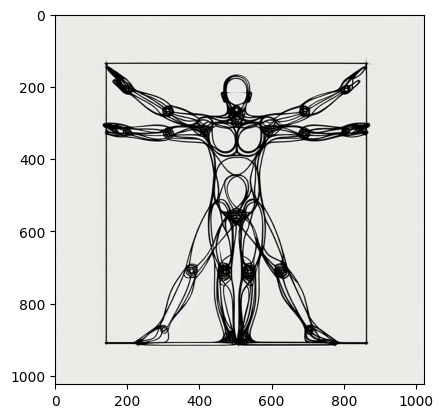

In [5]:
from matplotlib import pyplot as plt
model_prompt = make_prompt(human_prompt)
print(f"Prompt sent to model:\n{model_prompt}")
img = generate_drawing(human_prompt)
plt.imshow(img)

## Tracing and Visualizing Contours
The code below uses the OpenCV library to trace the edges of the generated image. It then visualizes the traced contours by drawing them on a blank canvas. Each contour is drawn with a different color to differentiate them. The resulting image provides a visual representation of the outlines of the generated drawing.

The downside of this approach is that it traces both sides of a line. This means that when tracing the edges of an image, the algorithm will detect and trace both the inner and outer boundaries of a line or shape. This can lead to duplicate contours being detected and drawn on the canvas.

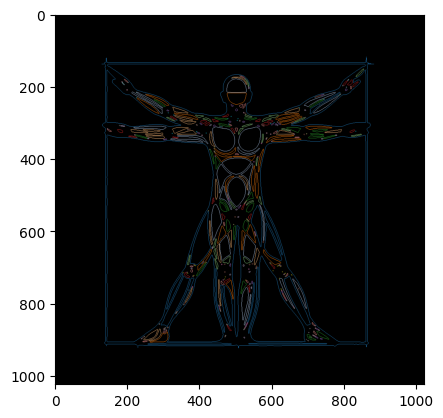

In [19]:
import cv2
import numpy as np

contours = trace_image(img)

# now we show the traced contours
contour_img = np.zeros_like(img)
# draw each contour with different color
for i, contour in enumerate(contours):
    # color from colormap 
    color = plt.cm.tab20(i / len(contours))[:3]
    cv2.drawContours(contour_img, contours, i, (color[0]*255, color[1]*255, color[2]*255), 1)
# show image
plt.imshow(contour_img)

## Scaling contours to fit a canvas
`scale_contours_to_canvas` is responsible for scaling a list of contours to fit within a canvas of a given size, with a margin around the edges.



In [26]:
canvas_contours = scale_contours_to_canvas(
    contours, 
    canvas_width=550, 
    canvas_height=850, 
    margin=200)


## generating gcode

G-code is a programming language used to control computer numerical control (CNC) machines. It consists of a series of commands that instruct the machine on how to move, position, and perform various operations. G-code is widely used in manufacturing and fabrication processes to automate the operation of CNC machines, such as 3D printers, milling machines, and laser cutters. It provides precise control over the machine's movements and enables the creation of complex shapes and designs.

RoboDK (a robot simulation program) also allows us to import G-code and turn it into a program that a robot arm can execute.

> **Warning:** It is important to exercise caution when using industrial robots, CNC machines, and 3D printers. Failure to verify the code that runs on these machines can lead to dangerous situations, including physical harm and damage to equipment. Always double-check and validate the code before executing it on these machines to ensure safety and proper operation.

If you want to hack on the source code, you could tweak the `make_gcode` function to do stuff like:
- Turn on the spindle of a CNC machine at the start of the program, turn off at the end.
- control the feedrate of a 3D printer extruder when the printhead comes into contact with the build plate


In [27]:
gcode = make_gcode(canvas_contours)
# print the first 10 lines of the gcode
print("Example of gcode contents:\n")
with open(gcode, 'r') as file:
    for i in range(10):
        print(file.readline().strip())

Example of gcode contents:

G21 ; Set units to mm
G90 ; Absolute positioning
G0 F30000
G0 Z50
G0 X198.48 Y-225.0
G0 Z0
G1 X198.48 Y220.533
G1 X197.922 Y219.975
G1 X197.922 Y216.625
G1 X197.364 Y216.067


## Using RoboDK to generate a drawing program for a UR10e robot
Now we teach our robot how to draw! This will load a simulation environment containing a robot and an easel. Using the RoboDK api, we can load the gcode and convert it into a robot program.

While running the program, we "draw" by pupulating the scene with tiny particles wherever the pen comes into contact with the canvas.

![Screenshot from 2024-02-05 13-30-06.png](<attachment:Screenshot from 2024-02-05 13-30-06.png>)
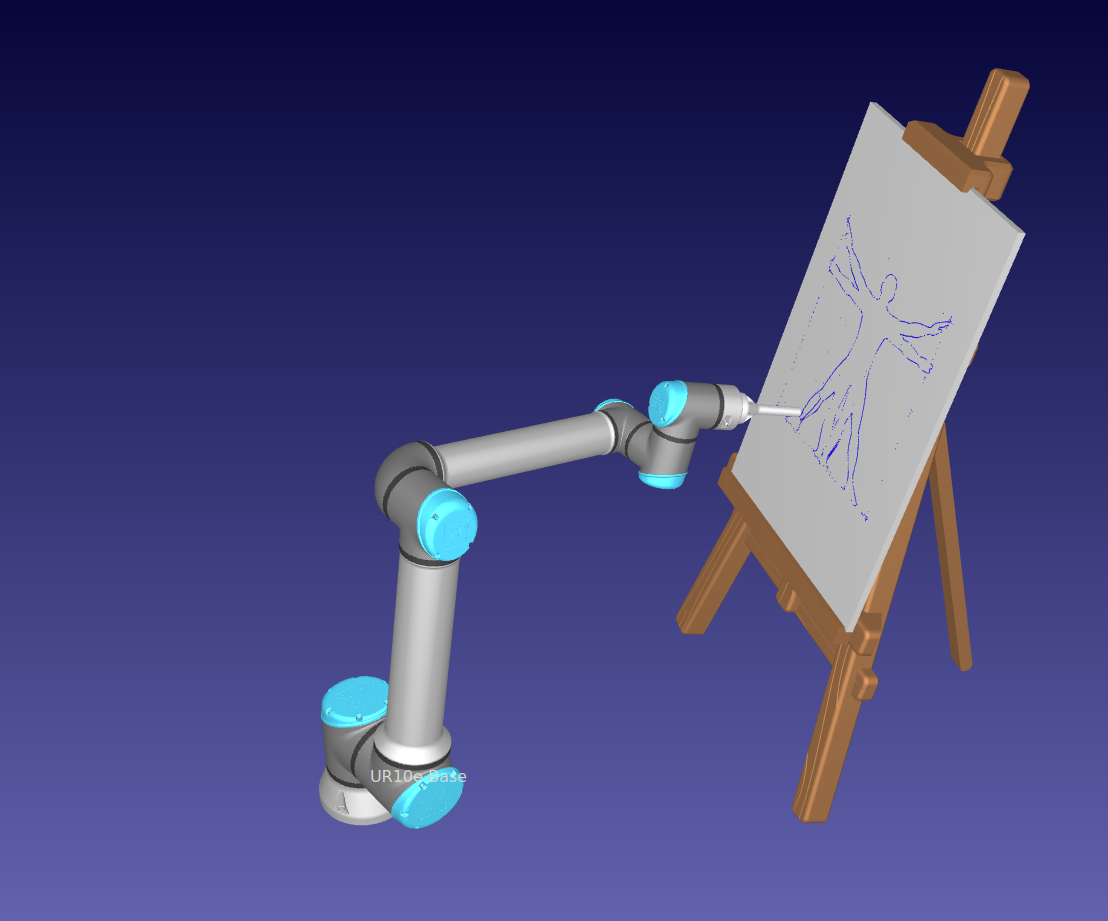

In [29]:
rdk = load_station()
make_robot_program(gcode, rdk, run = True)

2024-02-05 13:27:53,874 - unknown_module - INFO - Closing active station
2024-02-05 13:27:53,878 - unknown_module - INFO - Loading station from /home/juanb/Documents/code/robot_artist/simulation/main_station.rdk
2024-02-05 13:27:58,689 - unknown_module - INFO - Drawing...
2024-02-05 13:27:58,690 - unknown_module - INFO - Press CRTL+C to stop drawing
